# Importing Libraries

In [133]:
train_vals.shape

(59400, 40)

In [7]:
# Dataframe building and manipulation
import pandas as pd
import numpy as np

# Vizualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

'''Model Building'''
#PreProcessing
from sklearn.preprocessing import StandardScaler

#Model Stuff
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


# Importing DataFrames

In [8]:
# Dataframes we will use
train_labels = pd.read_csv('Data/training_set_labels.csv')
train_vals = pd.read_csv('Data/training_set_values.csv')

In [9]:
#For competition submission
test_vals = pd.read_csv('Data/test_set_values.csv')
sub_form = pd.read_csv('Data/SubmissionFormat.csv')

Displaying all columns because I want to

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
# Checking number of entries and features
print('train_vals:', train_vals.shape)
print('train_labels', train_labels.shape)
print('test_vals', test_vals.shape)

train_vals: (59400, 40)
train_labels (59400, 2)
test_vals (14850, 40)


### Merging our Train Values and Test Values into one dataframe

In [13]:
df = pd.merge(train_vals, train_labels,left_on='id', right_on='id',how='outer')

I'm creating a dataframe with columns I will consider. I included the available numerical data that was present. Some columns provided the same categorical information, so I left those out. Others had almost the same categorical information, just split into fewer or more classifications depending on the column. I experimented with those columns and chose the resulting columns since they appeared to do the best overall.

In [14]:
final_df = df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
               'public_meeting', 'basin', 'region','scheme_management', 'permit',
               'extraction_type', 'management_group', 'payment', 'water_quality',
               'quality_group', 'quantity', 'source_type', 'waterpoint_type_group',
               'status_group']]

# Cleaning

Formula to combine 'SWC', 'Trust', and 'None' classifications into 'Other' in *scheme_management*
since there are only a few entries for these classifications

In [15]:
def to_other(entry):
    if entry in ['SWC', 'Trust', 'None']:
        return 'Other'
    if entry is None:
        return 'Other'
    else:
        return entry

In [16]:
final_df.scheme_management.fillna(value='Other', inplace=True)

C:\Users\Cristian\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [17]:
final_df.scheme_management = final_df.scheme_management.apply(to_other)

C:\Users\Cristian\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Filling in nulls for *public_meeting* and *permit* where I consider the worst case scenario.

In [18]:
final_df.public_meeting.fillna(value=0, inplace=True)

In [19]:
final_df.permit.fillna(value=0, inplace=True)

In [20]:
final_df.head()

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,basin,region,scheme_management,permit,extraction_type,management_group,payment,water_quality,quality_group,quantity,source_type,waterpoint_type_group,status_group
0,6000.0,1390,34.938093,-9.856322,109,True,Lake Nyasa,Iringa,VWC,False,gravity,user-group,pay annually,soft,good,enough,spring,communal standpipe,functional
1,0.0,1399,34.698766,-2.147466,280,0,Lake Victoria,Mara,Other,True,gravity,user-group,never pay,soft,good,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,686,37.460664,-3.821329,250,True,Pangani,Manyara,VWC,True,gravity,user-group,pay per bucket,soft,good,enough,dam,communal standpipe,functional
3,0.0,263,38.486161,-11.155298,58,True,Ruvuma / Southern Coast,Mtwara,VWC,True,submersible,user-group,never pay,soft,good,dry,borehole,communal standpipe,non functional
4,0.0,0,31.130847,-1.825359,0,True,Lake Victoria,Kagera,Other,True,gravity,other,never pay,soft,good,seasonal,rainwater harvesting,communal standpipe,functional


Turning True and False to binary integer inputs

In [21]:
final_df[['public_meeting', 'permit']] = final_df[['public_meeting', 'permit', ]].astype(int)

C:\Users\Cristian\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Making Dummies for the dataframe and splitting between our target variable and
everything else

In [22]:
X = pd.get_dummies(final_df.iloc[:,:-1])
y = final_df.status_group

Train test split our data twice to prevent any influence from our test data onto our train data.

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42, stratify=y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, test_size=.2, random_state=42)

# Models
### I will run models and print the resulting confusion matrix and classification report

Scaling numerical data. Even though I scaled numerical data, after running several models on the scaled data the models that used them tended to do worse.

In [24]:
numeric = X2_train.iloc[:, 0:5]
cat = X2_train.iloc[:, 5:]

ss = StandardScaler()
X2_train_sc = ss.fit_transform(numeric)
numeric2_sc = pd.DataFrame(X2_train_sc, index=numeric.index, columns=numeric.columns)

scaled_df_train2 = pd.concat([numeric2_sc, cat], axis=1)

In [ ]:
numeric = X2_train.iloc[:, 0:5]
cat = X2_train.iloc[:, 5:]

ss = StandardScaler()
X2_train_sc = ss.fit_transform(numeric)
numeric2_sc = pd.DataFrame(X2_train_sc, index=numeric.index, columns=numeric.columns)

scaled_df_train2 = pd.concat([numeric2_sc, cat], axis=1)

### K-Nearest Neighbors

In [25]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(scaled_df_train2,y2_train)
knn_preds = knn.predict(X2_test)

knn_cm_test = confusion_matrix(y2_test, knn_preds)
print(knn_cm_test)
print(classification_report(y2_test, knn_preds))

[[4459   83  663]
 [ 593   16  121]
 [2783   63  723]]
                         precision    recall  f1-score   support

             functional       0.57      0.86      0.68      5205
functional needs repair       0.10      0.02      0.04       730
         non functional       0.48      0.20      0.28      3569

               accuracy                           0.55      9504
              macro avg       0.38      0.36      0.33      9504
           weighted avg       0.50      0.55      0.48      9504



#### Final Model with KNN

In [26]:
knn_final = KNeighborsClassifier(n_neighbors=5)
knn_final.fit(X_train, y_train)
knn_final_preds = knn_final.predict(X_test)
knn_final_cm = confusion_matrix(y_test, knn_final_preds)
print(knn_final_cm)
print(classification_report(y_test, knn_final_preds))

[[5176  164 1112]
 [ 524  163  176]
 [1750   90 2725]]
                         precision    recall  f1-score   support

             functional       0.69      0.80      0.74      6452
functional needs repair       0.39      0.19      0.25       863
         non functional       0.68      0.60      0.64      4565

               accuracy                           0.68     11880
              macro avg       0.59      0.53      0.54     11880
           weighted avg       0.67      0.68      0.67     11880



### Naive Bayes

In [27]:
nb = GaussianNB()
nb.fit(scaled_df_train2, y2_train)
nb_preds = nb.predict(X2_test)

nb_cm_test = confusion_matrix(y2_test, nb_preds)
print(nb_cm_test)
print(classification_report(y2_test, nb_preds))

[[3575 1616   14]
 [ 439  290    1]
 [2292 1227   50]]
                         precision    recall  f1-score   support

             functional       0.57      0.69      0.62      5205
functional needs repair       0.09      0.40      0.15       730
         non functional       0.77      0.01      0.03      3569

               accuracy                           0.41      9504
              macro avg       0.48      0.37      0.27      9504
           weighted avg       0.61      0.41      0.36      9504



In [28]:
nb_final = GaussianNB()
nb_final.fit(X_train, y_train)
nb_final_preds = nb.predict(X_test)
nb_final_cm = confusion_matrix(y_test, nb_final_preds)
print(classification_report(y_test, nb_final_preds))

                         precision    recall  f1-score   support

             functional       0.56      0.68      0.61      6452
functional needs repair       0.09      0.41      0.15       863
         non functional       0.86      0.02      0.03      4565

               accuracy                           0.40     11880
              macro avg       0.50      0.37      0.26     11880
           weighted avg       0.64      0.40      0.36     11880



### Random Forest

In [29]:
rf = RandomForestClassifier()
rf.fit(X2_train,y2_train)

preds_rf_X2test = rf.predict(X2_test)

print(classification_report(y2_test, preds_rf_X2test))

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      5205
functional needs repair       0.50      0.30      0.38       730
         non functional       0.82      0.77      0.79      3569

               accuracy                           0.79      9504
              macro avg       0.70      0.65      0.67      9504
           weighted avg       0.78      0.79      0.78      9504



Example of using scaled numerical data

In [30]:
rf_sc = RandomForestClassifier()

rf_sc.fit(scaled_df_train2, y2_train)
rf_sc_preds = rf_sc.predict(X2_test)
print(classification_report(y2_test, rf_sc_preds))
print(confusion_matrix(y2_test, rf_sc_preds))

                         precision    recall  f1-score   support

             functional       0.67      0.95      0.79      5205
functional needs repair       0.80      0.01      0.01       730
         non functional       0.85      0.51      0.64      3569

               accuracy                           0.71      9504
              macro avg       0.78      0.49      0.48      9504
           weighted avg       0.75      0.71      0.67      9504

[[4956    1  248]
 [ 653    4   73]
 [1735    0 1834]]


In [31]:
rf_final = RandomForestClassifier()
rf_final.fit(X_train, y_train)

rf_final_preds = rf_final.predict(X_test)
rf_final_cm = confusion_matrix(y_test, rf_final_preds)

print(rf_final_cm)
print(classification_report(y_test, rf_final_preds))

[[5632  224  596]
 [ 444  271  148]
 [ 897   79 3589]]
                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6452
functional needs repair       0.47      0.31      0.38       863
         non functional       0.83      0.79      0.81      4565

               accuracy                           0.80     11880
              macro avg       0.70      0.66      0.67     11880
           weighted avg       0.79      0.80      0.79     11880



### Bagging

In [32]:
bag = BaggingClassifier()
bag.fit(X2_train, y2_train)

preds_bag_test = bag.predict(X2_test)

bag_cm_test = confusion_matrix(y2_test, preds_bag_test)
print(bag_cm_test)
print(classification_report(y2_test, preds_bag_test))

[[4578  159  468]
 [ 410  209  111]
 [ 816   72 2681]]
                         precision    recall  f1-score   support

             functional       0.79      0.88      0.83      5205
functional needs repair       0.47      0.29      0.36       730
         non functional       0.82      0.75      0.79      3569

               accuracy                           0.79      9504
              macro avg       0.70      0.64      0.66      9504
           weighted avg       0.78      0.79      0.78      9504



In [33]:
bag_final = BaggingClassifier()
bag_final.fit(X_train, y_train)

bag_final_preds = bag_final.predict(X_test)
bag_final_cm = confusion_matrix(y_test, bag_final_preds)
print(bag_final_cm)
print(classification_report(y_test, bag_final_preds))

[[5648  217  587]
 [ 448  279  136]
 [1018   99 3448]]
                         precision    recall  f1-score   support

             functional       0.79      0.88      0.83      6452
functional needs repair       0.47      0.32      0.38       863
         non functional       0.83      0.76      0.79      4565

               accuracy                           0.79     11880
              macro avg       0.70      0.65      0.67     11880
           weighted avg       0.78      0.79      0.78     11880



### Extra Trees

In [34]:
et = ExtraTreesClassifier()
et.fit(X2_train,y2_train)

preds_et_test = et.predict(X2_test)

et_cm_test = confusion_matrix(y2_test, preds_et_test)
print(et_cm_test)
print(classification_report(y2_test, preds_et_test))

[[4430  189  586]
 [ 367  239  124]
 [ 739   88 2742]]
                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      5205
functional needs repair       0.46      0.33      0.38       730
         non functional       0.79      0.77      0.78      3569

               accuracy                           0.78      9504
              macro avg       0.69      0.65      0.66      9504
           weighted avg       0.77      0.78      0.77      9504



In [35]:
et_final = ExtraTreesClassifier()
et_final.fit(X_train, y_train)

et_final_preds = et_final.predict(X_test)
et_final_cm = confusion_matrix(y_test, et_final_preds)
print(classification_report(y_test, et_final_preds))

                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      6452
functional needs repair       0.44      0.33      0.38       863
         non functional       0.81      0.78      0.79      4565

               accuracy                           0.79     11880
              macro avg       0.68      0.65      0.67     11880
           weighted avg       0.78      0.79      0.78     11880



### Grid Search

Running a grid search to test out several combinations of models. This will take *Forever*

In [36]:
rf_gs = RandomForestClassifier()

In [37]:
param_grid = {'criterion':['gini', 'entropy'],
              'min_impurity_split':[1e-7,.15],
              'max_depth': [3,10],
              'class_weight': [None, 'balanced'],
              'max_features': ['sqrt', None]}

In [38]:
import warnings
warnings.filterwarnings("ignore")

gs = GridSearchCV(estimator=rf_gs, param_grid=param_grid, cv=5)
gs.fit(X2_train, y2_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Running a model with the best parameters obtained from the grid search

In [39]:
gs_be = gs.best_estimator_
gs_be.fit(X2_train, y2_train)
preds_gs = gs_be.predict(X2_test)

In [40]:
gs_cm = confusion_matrix(y2_test, preds_gs)
print(gs_cm)
print(classification_report(y2_test, preds_gs))

[[4911   23  271]
 [ 617   57   56]
 [1426    3 2140]]
                         precision    recall  f1-score   support

             functional       0.71      0.94      0.81      5205
functional needs repair       0.69      0.08      0.14       730
         non functional       0.87      0.60      0.71      3569

               accuracy                           0.75      9504
              macro avg       0.75      0.54      0.55      9504
           weighted avg       0.77      0.75      0.72      9504



## XGB

In [41]:
xgb = XGBClassifier()
xgb.fit(X2_train, y2_train)

xgb_preds = xgb.predict(X2_test)
xgb_cm = confusion_matrix(y2_test, xgb_preds)

print(xgb_cm)
print(classification_report(y2_test, xgb_preds))

[[4758   54  393]
 [ 474  155  101]
 [ 993   21 2555]]
                         precision    recall  f1-score   support

             functional       0.76      0.91      0.83      5205
functional needs repair       0.67      0.21      0.32       730
         non functional       0.84      0.72      0.77      3569

               accuracy                           0.79      9504
              macro avg       0.76      0.61      0.64      9504
           weighted avg       0.79      0.79      0.77      9504



### SMOTE
##### I will use SMOTE to balance classes evenly. This should help out with the class imbalances to some extent. I will try combining this balance with some of the models and see how they result.

In [42]:
sm = SMOTE(random_state=42)
X2_train_os, y2_train_os = sm.fit_sample(X2_train, y2_train)

#### SMOTE + RF

In [42]:
rf_os = RandomForestClassifier()
rf_os.fit(X2_train_os, y2_train_os)

preds_os = rf_os.predict(X2_test)

print(classification_report(y2_test, preds_os))

                         precision    recall  f1-score   support

             functional       0.82      0.83      0.82      5205
functional needs repair       0.42      0.43      0.42       730
         non functional       0.81      0.78      0.79      3569

               accuracy                           0.78      9504
              macro avg       0.68      0.68      0.68      9504
           weighted avg       0.78      0.78      0.78      9504



In [43]:
y2_train_os.value_counts()

functional needs repair    20602
non functional             20602
functional                 20602
Name: status_group, dtype: int64

After looking at the f1-scores and how well each model did, I decided that using a Random Forest Model paired with using SMOTE was the best. While functional and non-functional is about the same for other models, this one does a little better in classifying wells that need repair.

In [44]:
sm_final = SMOTE(random_state=42)
X_train_os, y_train_os = sm_final.fit_sample(X_train, y_train)

rf_final_os = RandomForestClassifier()
rf_final_os.fit(X_train, y_train)

rf_final_os_preds = rf_final_os.predict(X_test)
rf_final_os_cm = confusion_matrix(y_test, rf_final_os_preds)

print(rf_final_os_cm)
print(classification_report(y_test, rf_final_os_preds))

[[5637  214  601]
 [ 434  280  149]
 [ 914   78 3573]]
                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6452
functional needs repair       0.49      0.32      0.39       863
         non functional       0.83      0.78      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.71      0.66      0.68     11880
           weighted avg       0.79      0.80      0.79     11880



I plot the confusion matrix for the random forest and SMOTE combination.

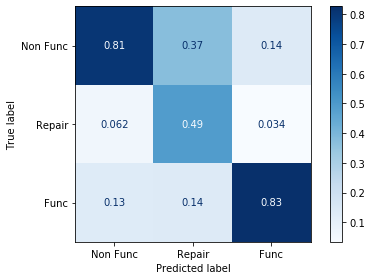

In [82]:
plot_confusion_matrix(rf_final_os, X_test, y_test, display_labels=['Non Func', 'Repair', 'Func'],  cmap=plt.cm.Blues, normalize='pred')
plt.tight_layout()
plt.savefig('Images/iamconfusion.png')

#### SMOTE + Bagging

In [47]:
bag_os = BaggingClassifier()
bag_os.fit(X2_train_os, y2_train_os)

preds_bag_os_test = bag.predict(X2_test)

bag_os_cm_test = confusion_matrix(y2_test, preds_bag_os_test)
print(bag_os_cm_test)
print(classification_report(y2_test, preds_bag_os_test))

[[4578  159  468]
 [ 410  209  111]
 [ 816   72 2681]]
                         precision    recall  f1-score   support

             functional       0.79      0.88      0.83      5205
functional needs repair       0.47      0.29      0.36       730
         non functional       0.82      0.75      0.79      3569

               accuracy                           0.79      9504
              macro avg       0.70      0.64      0.66      9504
           weighted avg       0.78      0.79      0.78      9504



#### SMOTE + Extra Trees

In [48]:
et_os = ExtraTreesClassifier()
et_os.fit(X2_train_os,y2_train_os)

preds_et_os_test = et.predict(X2_test)

et_os_cm_test = confusion_matrix(y2_test, preds_et_os_test)
print(et_os_cm_test)
print(classification_report(y2_test, preds_et_os_test))

[[4430  189  586]
 [ 367  239  124]
 [ 739   88 2742]]
                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      5205
functional needs repair       0.46      0.33      0.38       730
         non functional       0.79      0.77      0.78      3569

               accuracy                           0.78      9504
              macro avg       0.69      0.65      0.66      9504
           weighted avg       0.77      0.78      0.77      9504



#### SMOTE + XGB

In [49]:
xgb_os = XGBClassifier()
xgb_os.fit(X_train_os, y_train_os)
xgb_os_preds = xgb.predict(X_test)

print(classification_report(y_test, xgb_os_preds))

                         precision    recall  f1-score   support

             functional       0.77      0.91      0.83      6452
functional needs repair       0.62      0.20      0.30       863
         non functional       0.84      0.73      0.78      4565

               accuracy                           0.79     11880
              macro avg       0.74      0.61      0.64     11880
           weighted avg       0.78      0.79      0.77     11880



# Plotting feature importances

In [50]:
def plot_feature_importances(model):
    n_features = X2_train.shape[1]
    features = dict(zip(X2_train.columns.values, model.feature_importances_))
    f_sorted = dict(sorted(features.items(), key=lambda d: d[1], reverse=True))
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), f_sorted.values(), align='center') 
    plt.yticks(np.arange(n_features), f_sorted.keys()) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    return f_sorted

I am plotting the features of our final random forest model since that is the model I chose.

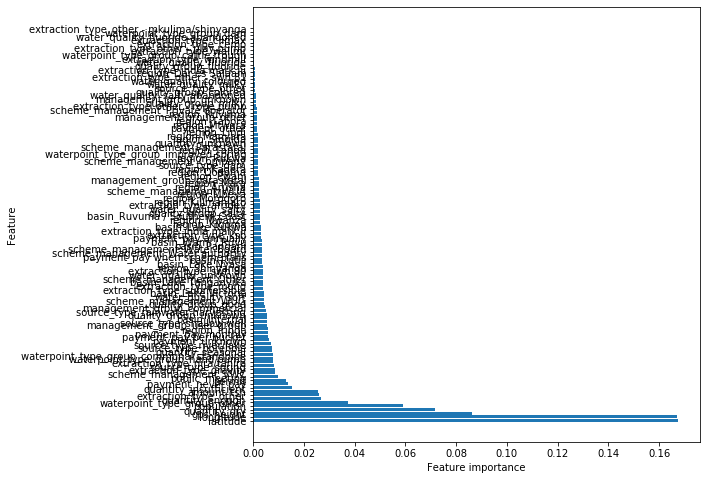

In [51]:
feature_importances = plot_feature_importances(rf_final_os)

Getting Top 10 Features and then plotting them.

In [52]:
top10 = dict(zip(list(feature_importances.keys())[:10],list(feature_importances.values())))

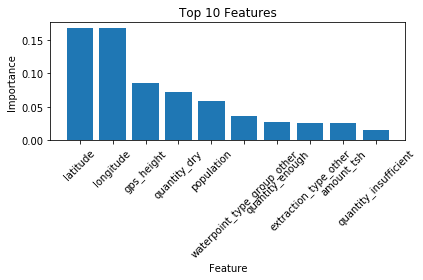

In [54]:
plt.bar(top10.keys(), top10.values())
plt.xticks(rotation=45)
plt.title('Top 10 Features')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('Images/importances.png')

# EDA

Viewing the class imbalance from the data we have

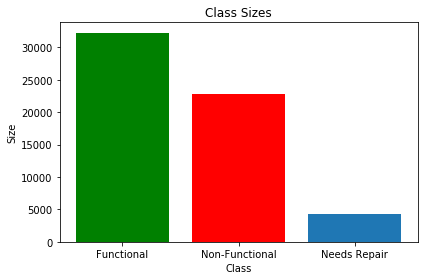

In [75]:
class_sizes = [len(functional.status_group), len(non_functional.status_group), len(needs_repair.status_group)]
classes = 'Functional', 'Non-Functional', 'Needs Repair'
plt.title('Class Sizes')
plt.xlabel('Class')
plt.ylabel('Size')
plt.bar(classes, class_sizes, color=['g','r','C0'])
plt.tight_layout()
plt.savefig('Images/class_size.png')

Splitting between the 3 classifications for easier calculations

In [57]:
functional = final_df[final_df.status_group == 'functional']
non_functional = final_df[final_df.status_group == 'non functional']
needs_repair = final_df[final_df.status_group == 'functional needs repair']

Getting a map_df and excluding the outlier.

In [58]:
map_df = df[df.longitude>25]

In [60]:
my_map = plt.imread('Images/map.png')

Getting the boundaries of the map so I can create a visualization. I rounded based on the website I used to get the image.

In [61]:
print(map_df.longitude.min(),
      map_df.longitude.max(),
      map_df.latitude.min(),
      map_df.latitude.max())

29.6071219 40.34519307 -11.64944018 -0.99846435


In [62]:
#BBox = ((longitude.min(), longitude.max(),      
#         latitude.min(), latitude.max()))
BBox = ((29.607, 40.345, -11.649, -0.998))

Creating map visualization.

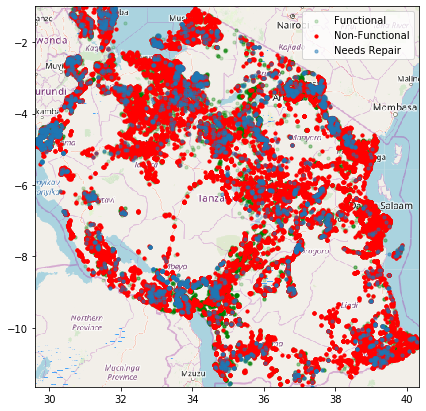

In [63]:
fig, ax = plt.subplots(figsize=(8,7))

#plot long and lat
ax.scatter(functional.longitude, functional.latitude, alpha=.2, zorder=1, s=10, color='g')
ax.scatter(non_functional.longitude, non_functional.latitude, zorder=1, s=10, color='r')
ax.scatter(needs_repair.longitude, needs_repair.latitude, alpha=.5, zorder=1, s=10)

#set boundaries
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

#use map image and place legend
ax.imshow(my_map, zorder=0, extent = BBox, aspect= 'equal')
plt.legend(['Functional', 'Non-Functional', 'Needs Repair'])

#save
plt.savefig('Images/map_of_wells.png')

Getting a visualization of the population to see how many people each classification affects.

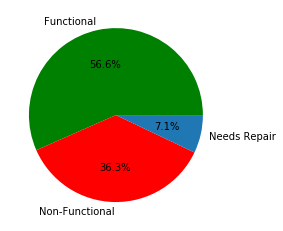

In [64]:
func_pop = functional.population.sum()
nonfunc_pop = non_functional.population.sum()
repair_pop = needs_repair.population.sum()

populations = [func_pop, nonfunc_pop, repair_pop]
pop_labels = ['Functional', 'Non-Functional', 'Needs Repair']

clrs = ['g', 'r', 'C0']

plt.pie(populations, labels=pop_labels, colors=clrs, autopct='%1.1f%%')

plt.savefig('Images/populations.png')

I wanted to explore the failure rate of each waterpoint type. I iterate through all the types and calculate the percent of how many are non-functional.

In [68]:
waterpoints = list(df.waterpoint_type.unique())
failure_rate_wp = {}

for w in waterpoints:
    temp_df = df[df.waterpoint_type == w]
    total = len(temp_df.status_group)
    failure = len(temp_df[temp_df.status_group=='non functional'])
    failure_rate_wp[w] = failure/total

In [69]:
failure_rate_wp = dict(sorted(failure_rate_wp.items(), key=lambda x: x[1], reverse=True))

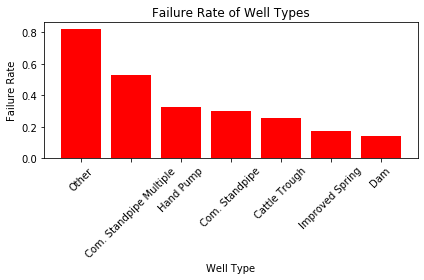

In [70]:
failure_labels = ['Other', 'Com. Standpipe Multiple', 'Hand Pump',
                  'Com. Standpipe', 'Cattle Trough', 'Improved Spring', 'Dam']
plt.bar(failure_labels, failure_rate_wp.values(), color='r')
plt.xticks(rotation=45)
plt.xlabel('Well Type')
plt.ylabel('Failure Rate')
plt.title('Failure Rate of Well Types')
plt.tight_layout()
plt.savefig('Images/failurerate.png')

I do the same thing as before to calculate the percent of non-functional wells for quantity levels.

In [71]:
quantities = list(df.quantity.unique())
quant_fail = {}

for q in quantities:
    temp_df = df[df.quantity == q]
    total = len(temp_df.status_group)
    failure = len(temp_df[temp_df.status_group=='non functional'])
    quant_fail[q] = failure/total
    

In [72]:
quant_fail = dict(sorted(quant_fail.items(), key=lambda x: x[1], reverse=True))

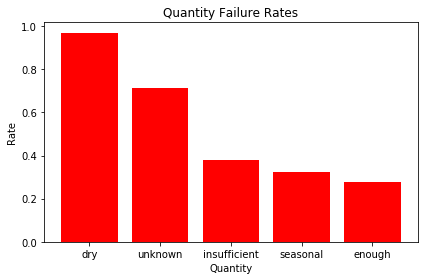

In [73]:
plt.bar(quant_fail.keys(), quant_fail.values(), color='r')
plt.title("Quantity Failure Rates")
plt.xlabel('Quantity')
plt.ylabel('Rate')
plt.tight_layout()
plt.savefig('Images/quantity.png')

Same as before, we are just getting the top 5 installers since there are so many.

In [76]:
def get_installers(df):
    installers = dict(df.installer.value_counts()[:15])
    names = sorted(installers.keys())
    total = sum(installers.values())
    for name in names:
        installers[name] = installers[name]/total
    return dict(sorted(installers.items(), key=lambda x:x[1],reverse=True))

In [77]:
installers = get_installers(df)

In [78]:
values = {'DWE': 0.5961222252671965,
 'Government': 0.06251712798026857,
 'RWE': 0.04131268840778295,
 'Commu': 0.03631131816936147,
 'DANIDA': 0.035968758563990136}

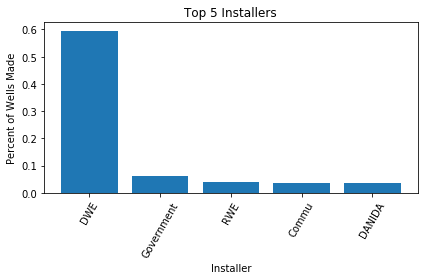

In [79]:
bar = plt.bar(values.keys(), values.values())
plt.xticks(rotation=60)
plt.xlabel('Installer')
plt.ylabel('Percent of Wells Made')
plt.title('Top 5 Installers')
plt.tight_layout()
plt.savefig('Images/func_installer.png')

Getting the number of wells are non-functional for installer 'DWE'.

In [80]:
temp = df[df.installer=='DWE']
total = len(temp.installer)
fails = len(temp[temp.status_group=='non functional'])

In [81]:
print(fails/total)

0.3647281921618205


# Submission Stuff

In [84]:
sub_df = test_vals[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
                    'public_meeting', 'basin', 'region','scheme_management', 'permit',
                    'extraction_type', 'management_group', 'payment', 'water_quality',
                    'quality_group', 'quantity', 'source_type', 'waterpoint_type_group']]


sub_df.scheme_management.fillna(value='Other', inplace=True)
sub_df.scheme_management = final_df.scheme_management.apply(to_other)
sub_df.public_meeting.fillna(value=0, inplace=True)
sub_df.permit.fillna(value=0, inplace=True)
sub_df[['public_meeting', 'permit']] = sub_df[['public_meeting', 'permit', ]].astype(int)

In [102]:
sub_df = pd.get_dummies(sub_df)

In [122]:
zero = [0]*14850
sub_df['extraction_type_other - mkulima/shinyanga'] = zero

In [95]:
sub_sm = SMOTE(random_state=42)
X_sub_train, y_sub_train = sub_sm.fit_sample(X, y)
submission_model = RandomForestClassifier()
submission_model.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [124]:
sub_preds = submission_model.predict(sub_df)

In [126]:
sub_form.status_group = sub_preds

In [130]:
sub_form.to_csv('SubmissionFormat.csv', index=False)

# We got an f1-score of about .41 in our submission. There is still a lot of work to do.